# Mapping Short-Term Rental Patterns and Housing Pressure Signals in Cape Town

**Purpose:**  
This notebook models and analyzes how Airbnb activity patterns relate to housing pressure in Cape Town, using only internal metrics (price, density, reviews, availability). It identifies which Airbnb-related factors contribute most to an internal “pressure index” that captures affordability stress.


## Import required libraries

In [18]:
# Import libraries
import sys
sys.path.append("..") # Move up project root to import config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Enable inline plotting (for Jupyter)
%matplotlib inline

# Import config file
import config

# For interactive maps
import folium
import json
from folium.plugins import MarkerCluster

## Define helper functions

In [13]:
# Helper function to load files
def load_csv(path, compression=None, name="Dataset"):
    """ Load CSV with optional compression and display message."""
    if os.path.exists(path):
        df = pd.read_csv(path, compression=compression)
        if df.empty:
            print(f"{name} loaded but is empty.")
        else:
            print(f"{name} loaded successfully.")
        return df
    else:
        print(f"{name} not found: {path}")
        return None

    
# Helper function to check for missing values
def check_missing_data(df, name="Dataset"):
    missing_values = df.isnull().sum().reset_index()
    missing_values.columns = ["Column", "Missing Values"]
    missing_values["% Missing"] = (missing_values["Missing Values"] / 
                                   len(df) * 100).round(2)
    total_missing = missing_values["Missing Values"].sum()

    if total_missing == 0:
        print(f"No missing data found in {name}.")
    else:
        print(f"Missing data summary for {name}:")
        print(missing_values[missing_values["Missing Values"] > 0])

## Load the datasets

In [14]:
# Define path to the dataset
filepath_listings = config.LISTINGS_FILE
filepath_calendar = config.CALENDAR_FILE
filepath_gdf = config.GDF_FILE

# Load listings
listings_df = load_csv(filepath_listings, name="Listings")

# Load calendar
calendar_df = load_csv(filepath_calendar, compression="gzip", name="Calendar")

# Load neighbourhoods
wards_gdf = gpd.read_file(filepath_gdf)

# Load aggregated wards
wards_aggregate = load_csv("../data/processed/wards_aggregate.csv")

Listings loaded successfully.
Calendar loaded successfully.
Dataset loaded successfully.


## Define Pressure Index

In [15]:
# Initialise copy of original data
wards_agg_scaled = wards_aggregate.copy()

# Apply MinMax scaling to chosen columns
scaler = MinMaxScaler()

wards_agg_scaled[['norm_price','norm_density', 
                'norm_reviews_pm','norm_availability']] = scaler.fit_transform(
wards_aggregate[['average_price','listing_density',
                'average_reviews_per_month','average_availability']])

# Invert availability (low availability = high pressure)
wards_agg_scaled['norm_availability'] = 1 - wards_agg_scaled[
                                        'norm_availability']

# Calculate pressure index (sum of normalized metrics)
wards_agg_scaled['pressure_index'] = (wards_agg_scaled['norm_price']
    + wards_agg_scaled['norm_density']
    + wards_agg_scaled['norm_reviews_pm']
    + wards_agg_scaled['norm_availability'])

## Model Internal Relationships
Assigned the pressure index as the target and the 4 normalized factors as predictors to see which ones explain the most variance.

In [ ]:
# Identify features and target
features = ['norm_price','norm_density','norm_reviews_pm','norm_availability']
target = "pressure_index"

X = wards_agg_scaled[features]
y = wards_agg_scaled[target]

# Impute missing values in features with column mean because X contains NaNs
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(wards_agg_scaled[features])

# Impute missing values in target (pressure_index) with mean
y = wards_agg_scaled[target].fillna(wards_agg_scaled[target].mean())

In [21]:
# Train test split (training set: 80% and test set: 20%)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                 random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate the models
print("Linear Regression R²:", round(r2_score(y_test, y_pred_lr), 3))
print("Random Forest R²:", round(r2_score(y_test, y_pred_rf), 3))

Linear Regression R²: 0.975
Random Forest R²: 0.568


R² shows Random Forest fits slightly better, capturing non-linear patterns.

## Feature Importance

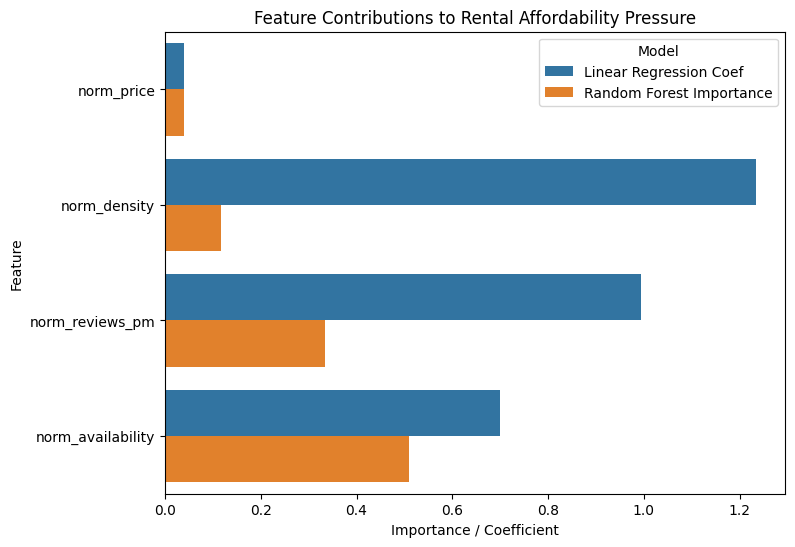

In [26]:
# Linear Regression coefficients
lr_coefficients = pd.Series(lr.coef_, index=features)

# Random Forest feature importances
rf_importances = pd.Series(rf.feature_importances_, index=features)

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Linear Regression Coef': lr_coefficients,
    'Random Forest Importance': rf_importances
})

# Melt the DataFrame for seaborn plotting
importance_melted = importance_df.melt(id_vars='Feature', 
                                       value_vars=['Linear Regression Coef', 
                                                   'Random Forest Importance'],
                                    var_name='Model', value_name='Importance')

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=importance_melted, x='Importance', y='Feature', hue='Model')
plt.title("Feature Contributions to Rental Affordability Pressure")
plt.xlabel("Importance / Coefficient")
plt.ylabel("Feature")
plt.legend(title='Model')
plt.show()


In [28]:
wards_agg_scaled.to_csv("../data/processed/wards_affordability_model.csv", index=False)

**Observations**
- Listing density, reviews per month, and availability drive housing pressure, while price has minimal impact.
- Linear Regression highlights density and reviews, whereas Random Forest prioritizes availability, showing non-linear interactions; both agree price is least important.
- High Airbnb activity, not just high prices, creates affordability and availability stress across wards.
- Bar plots and feature importance charts show which factors dominate pressure and reveal model differences for interpretation.